# Timeseries Forecasting with LSTM Neural Networks

_Authors: Kiefer Katovich (SF)_

---

### Learning Objectives
- Learn how to build a basic LSTM using Keras.
- Train the LSTM model on unemployment data and forecast to future data.
- Understand the different ways to fit the LSTM model for timeseries data.

### Lesson Guide
- [Introduction](#introduction)
	- [A note on the lesson content](#a-note-on-the-lesson-content)
- [Load the Keras modules](#load-the-keras-modules)
- [Prepare the unemployment data for timeseries modeling](#prepare-the-unemployment-data-for-timeseries-modeling)
	- [Create the first-order differenced unemployment rate](#create-the-first-order-differenced-unemployment-rate)
	- [Normalize the differenced unemployement data with `MinMaxScaler`](#normalize-the-differenced-unemployement-data-with-minmaxscaler)
	- [Split the timeseries into 50% train/test splits](#split-the-timeseries-into--traintest-splits)
- [Write a function to create the predictor and target data](#write-a-function-to-create-the-predictor-and-target-data)
	- [Create training and testing data for a lag of 1](#create-training-and-testing-data-for-a-lag-of-)
- [Reshape the data to work with the LSTM](#reshape-the-data-to-work-with-the-lstm)
- [Constructing the Keras model](#constructing-the-keras-model)
	- [Fit the LSTM model](#fit-the-lstm-model)
	- [Plot the original data, the training predictions and the testing predictions](#plot-the-original-data-the-training-predictions-and-the-testing-predictions)
- [LSTM with multiple lags as predictors](#lstm-with-multiple-lags-as-predictors)
- [Refraing the problem using the LSTM "time steps" dimension](#refraing-the-problem-using-the-lstm-time-steps-dimension)
	- [Rebuild and fit the LSTM model, and plot the predictions](#rebuild-and-fit-the-lstm-model-and-plot-the-predictions)


<a id="introduction"></a>
## Introduction
---

Modeling timeseries and forecasting with neural networks is a growing trend. The Long Short Term Memory (LSTM) recurrent neural network architecture is a popular choice when "context" or memory across time is a desired capability of the model.

In this walkthrough/codealong lecture we will be building an LSTM using the Keras framework to forecast stock market timeseries data. 

<a id="a-note-on-the-lesson-content"></a>
### A note on the lesson content

This codealong focuses primarily on the Keras implementation and application of LSTM neural networks. This lecture does not cover:
- The theory behind recurrent neural networks.
- The mathematics or theory behind the architecture of LSTM networks.

There are a variety of great resources to dive deeper into LSTM networks:
- [A beginners guide to recurrent networks and LSTMs](http://deeplearning4j.org/lstm.html#a-beginners-guide-to-recurrent-networks-and-lstms)
- [Understanding LSTMs](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- [This tutorial provides a great introduction to building a simple LSTM for timeseries forecasting.](http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/) which 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

sns.set_style('whitegrid')

%matplotlib inline

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

<a id="prepare-the-unemployment-data-for-timeseries-modeling"></a>
## Prepare the unemployment data for timeseries modeling
---

First we will load quarterly US unemployment data to do some basic forecasting using LSTMs. 

**Load the unemployment data from CSV file and perform any required cleaning.**

In [3]:
data = pd.read_csv('data/seasonally-adjusted-quarterly-us.csv')

In [ ]:
#alternatively
data = pd.read_csv('https://git.generalassemb.ly/Gopinaath/Unit-5_Gopi/raw/master/dsi-unit-5.09-nnet-timeseries_forecasting_lstms-lesson/datasets/seasonally-adjusted-quarterly-us.csv')

In [5]:
data.tail()

,Quarter,Seasonally adjusted quarterly U.S. unemployment rates from 1948 to 1993
170,1990Q3,5.6%
171,1990Q4,5.9%
172,1991Q1,6.5%
173,1991Q2,6.833%
174,Seasonally adjusted quarterly U.S. unemploymen...,NaN


In [6]:
data.columns = ['year_quarter', 'unemployment_rate']
data['unemployment_rate'] = data['unemployment_rate'].map(lambda x: float(str(x).replace('%','')))
data.head(3)

,year_quarter,unemployment_rate
0,1948Q1,3.733
1,1948Q2,3.667
2,1948Q3,3.767


In [7]:
data.shape

(175, 2)

In [8]:
data = data.dropna()

In [9]:
data.shape

(174, 2)

In [10]:
data['year_quarter'] = data['year_quarter'].apply(lambda x: x.replace('Q1','-03-31')
                                                             .replace('Q2','-06-30')
                                                             .replace('Q3','-09-30')
                                                             .replace('Q4','-12-31'))

data['year_quarter'] = data['year_quarter'].apply(pd.to_datetime)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174 entries, 0 to 173
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   year_quarter       174 non-null    datetime64[ns]
 1   unemployment_rate  174 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.1 KB


In [13]:
data.set_index('year_quarter',inplace=True)

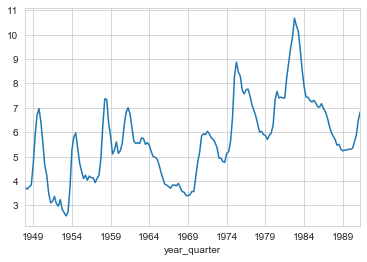

In [14]:
data['unemployment_rate'].plot()

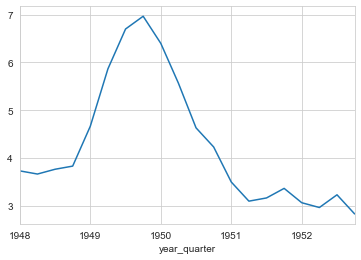

In [15]:
data['unemployment_rate'].head(4*5).plot()

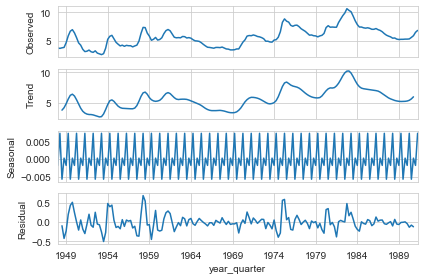

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(data['unemployment_rate'])
res.plot();

<a id="create-the-first-order-differenced-unemployment-rate"></a>
### Create the first-order differenced unemployment rate

In timeseries modeling the raw timeseries is rarely used. Typically we will use the first order differenced timeseries (or further order differences). Technically this differencing is done to ensure that the timeseries is stationary. 

However, there are more intuitive reasons why we would want to model the differences as opposed to the actual values. Take the AAPL stock price, for example, and imagine we are a day-trader. If we hold the AAPL stock, we are of course interested in having a model that can predict the price of the stock in the future. However, what we are *really* interested in is how the stock price will *change* in the future from the current point. It is more useful to say "the stock will go up by one point" than it is to say "the stock price will be 51." 

In [17]:
data['udiff'] = data['unemployment_rate'].diff(1)

In [18]:
data.head()

,unemployment_rate,udiff
year_quarter,,
1948-03-31,3.733,NaN
1948-06-30,3.667,-0.066
1948-09-30,3.767,0.100
1948-12-31,3.833,0.066
1949-03-31,4.667,0.834


In [20]:
data.shape

(174, 2)

In [21]:
data = data.dropna()

In [22]:
data.shape

(173, 2)

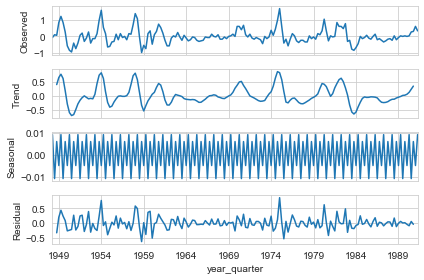

In [23]:
res = seasonal_decompose(data['udiff'])
res.plot();

<a id="normalize-the-differenced-unemployement-data-with-minmaxscaler"></a>
### Normalize the differenced unemployement data with `MinMaxScaler`

We want the rate to be restricted to the range -1 to 1.

> **Note:** the differencing will make the first value of the series a NaN value. Make sure to drop this from the dataset.

In [24]:
urate = data[['udiff']]
mms = MinMaxScaler(feature_range=(-1, 1))
urate = mms.fit_transform(urate)
print(urate.shape)

(173, 1)


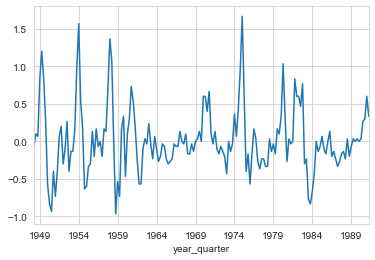

In [25]:
data['udiff'].plot()

<a id="split-the-timeseries-into--traintest-splits"></a>
### Split the timeseries into 50% train/test splits

We don't want a random train/test split in this case. With timeseries data, we are interested in how are model generalizes to future data in particular. Make the test set the second half of the data through time.

In [26]:
train_size = int(len(urate) * 0.50)
test_size = len(urate) - train_size
print(len(urate), train_size, test_size)

train, test = urate[0:train_size,:], urate[train_size:len(urate),:]

173 86 87


<a id="write-a-function-to-create-the-predictor-and-target-data"></a>
## Write a function to create the predictor and target data
---

The function will need to create a Y target and X predictor. The X predictor matrix will simply be the shifted versions of Y, our target unemployment timeseries. In other words, we want our features to be previous timesteps of the target data for given lags.

**Make a function with two arguments:**
1. The timeseries data.
2. The number of lags of the timeseries to have as predictors.

The default should create a dataset where X is the unemployment rate a given time (t) and Y is the unemployment rate at the next time (t + 1). At the default lag of 1 X will just be the unemployment timeseries of Y shifted back by 1.

> **Note:** make sure that the output X and Y are of the same length! You will need to slice off a row (at least - depends on the lag order).

In [27]:
udiff = data.udiff

In [28]:
udiff = udiff[0:8]
udiff

year_quarter
1948-06-30   -0.066
1948-09-30    0.100
1948-12-31    0.066
1949-03-31    0.834
1949-06-30    1.200
1949-09-30    0.833
1949-12-31    0.267
1950-03-31   -0.567
Name: udiff, dtype: float64

In [29]:
pd.DataFrame(dict(y=udiff.shift(1)))

,y
year_quarter,
1948-06-30,NaN
1948-09-30,-0.066
1948-12-31,0.100
1949-03-31,0.066
1949-06-30,0.834
1949-09-30,1.200
1949-12-31,0.833
1950-03-31,0.267


In [30]:
def create_data(timeseries, lag=1, as_array=True):
    if not isinstance(timeseries, pd.Series):
        timeseries = pd.Series(timeseries.ravel())
    y = timeseries[lag:]
    X = pd.DataFrame({'lag'+str(lag-i):timeseries.shift(-i) for i in range(0, lag)}).dropna().iloc[:-1, :]
    if not as_array:
        return X, y
    else:
        return X.values, y.values

In [31]:
X, y = create_data(udiff, lag=3)

In [32]:
X

array([[-0.066,  0.1  ,  0.066],
       [ 0.1  ,  0.066,  0.834],
       [ 0.066,  0.834,  1.2  ],
       [ 0.834,  1.2  ,  0.833],
       [ 1.2  ,  0.833,  0.267]])

In [ ]:
y

<a id="create-training-and-testing-data-for-a-lag-of-"></a>
### Create training and testing data for a lag of 1

Again, this means our X will just have 1 column.

In [33]:
lag = 1
trainX, trainY = create_data(train, lag)
testX, testY = create_data(test, lag)

## Reshape the data to work with the LSTM
---

<img src="https://miro.medium.com/max/1000/0*dhz-SOm-BW3rTEYa">

The format of data the LSTM expects is:

    [samples, time_steps, features]
    
Which is a 3D matrix.

We have been using 2D predictor matrices for our machine learning algorithms, where our X predictor matrix has been in the form:

    [samples, features]

Since we are working with timeseries (which is the data an LSTM expects), we are now required to provide information about the time.

You can use the `np.reshape()` command to turn your 2D X matrix into a 3D matrix that works for the LSTM matrix. We will talk about the "time step" dimension more down the line. 

> **Note:** In the case of a single lag this time step dimension is redundant. Later on, when we redesign the X matrix so that our individual features have multiple timesteps, this 3D format requirement will be clearer.

In [34]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [35]:
print(trainX.shape, trainY.shape)

(85, 1, 1) (85,)


<a id="constructing-the-keras-model"></a>
## Constructing the Keras model

Our LSTM model will be constructed in three parts.

First initialize the sequential layer-to-layer neural network model:

```python
model = Sequential()
```
    
Add an LSTM layer with 4 blocks/cells/neurons. We specify the `input_shape` to be the same dimensions as our features. You will notice that the `input_shape` below takes a tuple `(None, lag)`. The `None` is a placeholder for the timesteps of our features. By putting `None` we are simply avoiding specifying the timesteps.

```python
model.add(LSTM(4, input_shape=(None, lag)))
```

Add the output layer as a layer of one neuron that is fully connected to all of the previous LSTM cells:

```python
model.add(Dense(1))
```

In [36]:
model = Sequential()
model.add(LSTM(4, input_shape=(None, lag)))
model.add(Dense(1))

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4)                 96        
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


<a id="fit-the-lstm-model"></a>
### Fit the LSTM model

We can fit the model with these commands:

```python
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
```

Which will use the squared error loss (regression) and fit the data over 100 "epochs", or passes over the training data. It makes multiple passes because these LSTM neural networks learn according to a learning rate (which we have not specified).

The `optimizer='adam'` selects the type of algorithm for gradient descent. The Adam optimizer performs well and is often recommended for many types of neural network architectures.

In [38]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=1)

Train on 85 samples
Epoch 1/20
85/85 [==============================] - 1s 16ms/sample - loss: 0.1345
Epoch 2/20
85/85 [==============================] - 0s 2ms/sample - loss: 0.1089
Epoch 3/20
85/85 [==============================] - 0s 2ms/sample - loss: 0.0952
Epoch 4/20
85/85 [==============================] - 0s 2ms/sample - loss: 0.0886
Epoch 5/20
85/85 [==============================] - 0s 2ms/sample - loss: 0.0863
Epoch 6/20
85/85 [==============================] - 0s 2ms/sample - loss: 0.0839
Epoch 7/20
85/85 [==============================] - 0s 2ms/sample - loss: 0.0824
Epoch 8/20
85/85 [==============================] - 0s 2ms/sample - loss: 0.0814
Epoch 9/20
85/85 [==============================] - 0s 2ms/sample - loss: 0.0807
Epoch 10/20
85/85 [==============================] - 0s 2ms/sample - loss: 0.0799
Epoch 11/20
85/85 [==============================] - 0s 3ms/sample - loss: 0.0793
Epoch 12/20
85/85 [==============================] - 0s 2ms/sample - loss: 0.0786
Epoc

<a id="plot-the-original-data-the-training-predictions-and-the-testing-predictions"></a>
### Plot the original data, the training predictions and the testing predictions

You can predict from a Keras model much like with a sklearn model:

```python
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
```

Make sure you lag the data forward for training and testing!

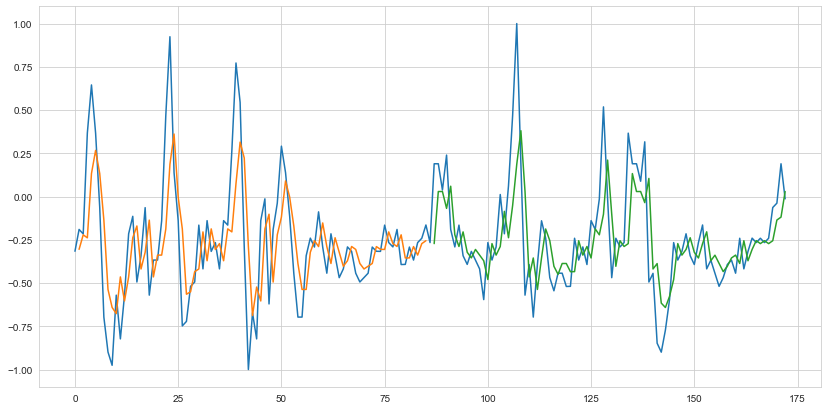

In [39]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(urate)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict
 
# shift test predictions for plotting
testPredictPlot = np.empty_like(urate)
testPredictPlot[:, :] = np.nan
testPredictPlot[-len(testPredict):, :] = testPredict
 
# plot baseline and predictions
plt.figure(figsize=(14,7))
plt.plot(urate)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

<a id="lstm-with-multiple-lags-as-predictors"></a>
## LSTM with multiple lags as predictors
---

We can instead predict the unemployment rate from not just the rate prior, but the `t-1`, `t-2`, and `t-3` rates.

You can use the function you wrote above to construct a new X and y where X now has 3 predictors according to the different lags.

Create the new Y and X variables below:

In [40]:
lag = 3
trainX, trainY = create_data(train, lag)
testX, testY = create_data(test, lag)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print(trainX[0:5])

[[[-0.31636916 -0.19027725 -0.2161033 ]]

 [[-0.19027725 -0.2161033   0.36726168]]

 [[-0.2161033   0.36726168  0.64527155]]

 [[ 0.36726168  0.64527155  0.36650209]]

 [[ 0.64527155  0.36650209 -0.06342575]]]


In [41]:
model = Sequential()
model.add(LSTM(4, input_shape=(None, lag)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=1)

Train on 83 samples
Epoch 1/50
83/83 [==============================] - 1s 15ms/sample - loss: 0.2026
Epoch 2/50
83/83 [==============================] - 0s 2ms/sample - loss: 0.1739
Epoch 3/50
83/83 [==============================] - 0s 2ms/sample - loss: 0.1586
Epoch 4/50
83/83 [==============================] - 0s 3ms/sample - loss: 0.1485
Epoch 5/50
83/83 [==============================] - 0s 2ms/sample - loss: 0.1415
Epoch 6/50
83/83 [==============================] - 0s 2ms/sample - loss: 0.1366
Epoch 7/50
83/83 [==============================] - 0s 2ms/sample - loss: 0.1321
Epoch 8/50
83/83 [==============================] - 0s 3ms/sample - loss: 0.1282
Epoch 9/50
83/83 [==============================] - 0s 3ms/sample - loss: 0.1243
Epoch 10/50
83/83 [==============================] - 0s 3ms/sample - loss: 0.1207
Epoch 11/50
83/83 [==============================] - 0s 2ms/sample - loss: 0.1168
Epoch 12/50
83/83 [==============================] - 0s 2ms/sample - loss: 0.1133
Epoc

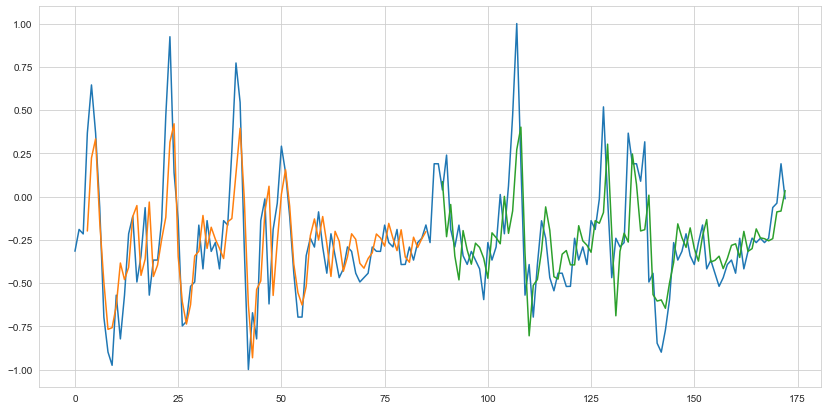

In [42]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(urate)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict
 
# shift test predictions for plotting
testPredictPlot = np.empty_like(urate)
testPredictPlot[:, :] = np.nan
testPredictPlot[-len(testPredict):, :] = testPredict
 
# plot baseline and predictions
plt.figure(figsize=(14,7))
plt.plot(urate)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

<a id="refraing-the-problem-using-the-lstm-time-steps-dimension"></a>
## Refraing the problem using the LSTM "time steps" dimension
---

Recall that our X matrix is converted to the form:

    [samples, time steps, features]
    
In the model we just made, we were saying that we had 3 different features, each of 1 time step long. This works fine, but it would be more appropriate to say that we had 1 feature with three different time steps, since that's what the data actually is (the unemplyment rate lagged to different degrees).

Instead of reshaping our data where the time step dimension is 1, we can instead reshape it so that the feature dimension is 1 and the time step dimension is 3, like so:

```python
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
```

In this toy example, this will for all intents and purposes be the same, but it is more appropriate to specify it this way since the variable is the same.

Recreate your training and testing data but reshaping your lags on the time dimension rather than the feature dimension:

In [43]:
lag = 3
trainX, trainY = create_data(train, lag)
testX, testY = create_data(test, lag)

In [44]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [45]:
print(trainX.shape)

(83, 3, 1)


<a id="rebuild-and-fit-the-lstm-model-and-plot-the-predictions"></a>
### Rebuild and fit the LSTM model, and plot the predictions

You will need to change the `input_shape` now to be `input_shape=(lag, 1)`, which indicates we have "lag" number of timesteps and 1 predictor/feature.

In [46]:
model = Sequential()
model.add(LSTM(4, input_shape=(lag, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=1)

Train on 83 samples
Epoch 1/50
83/83 [==============================] - 1s 16ms/sample - loss: 0.1476
Epoch 2/50
83/83 [==============================] - 0s 2ms/sample - loss: 0.1231
Epoch 3/50
83/83 [==============================] - 0s 2ms/sample - loss: 0.1173
Epoch 4/50
83/83 [==============================] - 0s 2ms/sample - loss: 0.1154
Epoch 5/50
83/83 [==============================] - 0s 2ms/sample - loss: 0.1135
Epoch 6/50
83/83 [==============================] - 0s 2ms/sample - loss: 0.1114
Epoch 7/50
83/83 [==============================] - 0s 2ms/sample - loss: 0.1102
Epoch 8/50
83/83 [==============================] - 0s 2ms/sample - loss: 0.1076
Epoch 9/50
83/83 [==============================] - 0s 2ms/sample - loss: 0.1059
Epoch 10/50
83/83 [==============================] - 0s 2ms/sample - loss: 0.1037
Epoch 11/50
83/83 [==============================] - 0s 2ms/sample - loss: 0.1007
Epoch 12/50
83/83 [==============================] - 0s 2ms/sample - loss: 0.0986
Epoc

In [50]:
testX

array([[[-0.26623623],
        [ 0.18951766],
        [ 0.18951766]],

       [[ 0.18951766],
        [ 0.18951766],
        [ 0.0375997 ]],

       [[ 0.18951766],
        [ 0.0375997 ],
        [ 0.23965059]],

       [[ 0.0375997 ],
        [ 0.23965059],
        [-0.19027725]],

       [[ 0.23965059],
        [-0.19027725],
        [-0.2913027 ]],

       [[-0.19027725],
        [-0.2913027 ],
        [-0.16521079]],

       [[-0.2913027 ],
        [-0.16521079],
        [-0.34219521]],

       [[-0.16521079],
        [-0.34219521],
        [-0.39232814]],

       [[-0.34219521],
        [-0.39232814],
        [-0.31712875]],

       [[-0.39232814],
        [-0.31712875],
        [-0.36726168]],

       [[-0.31712875],
        [-0.36726168],
        [-0.4181542 ]],

       [[-0.36726168],
        [-0.4181542 ],
        [-0.59589821]],

       [[-0.4181542 ],
        [-0.59589821],
        [-0.26623623]],

       [[-0.59589821],
        [-0.26623623],
        [-0.36726168]],

      

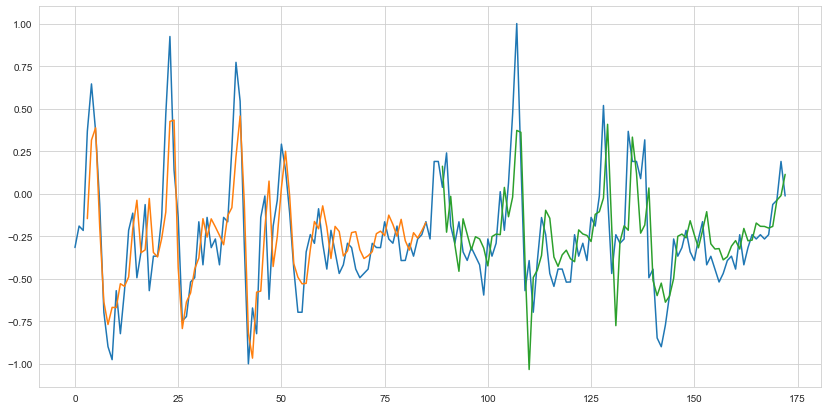

In [48]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(urate)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict
 
# shift test predictions for plotting
testPredictPlot = np.empty_like(urate)
testPredictPlot[:, :] = np.nan
testPredictPlot[-len(testPredict):, :] = testPredict
 
# plot baseline and predictions
plt.figure(figsize=(14,7))
plt.plot(urate)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()